Download the STARsolo Solo.out dir from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM5343850 and place it in a directory named `demultiplexed`.

In [1]:
import scanpy as sc
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np
import glob

In [2]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, figsize = [7, 7], fontsize = 14, format = 'svg')

In [3]:
for file in sorted(glob.glob('demultiplexed/*/Gene/UMIperCellSorted.txt')):
    print(file)

demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/UMIperCellSorted.txt


Then, generate barnyards:

In [5]:
legend = 'HYR__c21295__20210330_mcf-7_mmel'.split()

In [9]:
mtx = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/matrix.mtx'
features = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/features.tsv'
barcodes = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/barcodes.tsv'
data = sc.read_mtx(mtx)
data = data.T
features = pd.read_csv(features, header=None)
barcodes = pd.read_csv(barcodes, header=None)
data.var_names = features[0]
data.obs_names = barcodes[0]

In [15]:
sc.pp.calculate_qc_metrics(data, inplace=True)

In [17]:
data.obs.median()

n_genes_by_counts               904.000000
log1p_n_genes_by_counts           6.807935
total_counts                   1439.500000
log1p_total_counts                7.272746
pct_counts_in_top_50_genes       27.381348
pct_counts_in_top_100_genes      37.420741
pct_counts_in_top_200_genes      49.830459
pct_counts_in_top_500_genes      72.409996
dtype: float64

In [12]:
adata.write('geo/'+'HYR__c21295__20210330_mcf-7_mmel_S5'+'.raw.hdf5')

In [6]:
mtx = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/matrix.mtx'
features = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/features.tsv'
barcodes = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/barcodes.tsv'
data = sc.read_mtx(mtx)
data = data.T
features = pd.read_csv(features, header=None)
barcodes = pd.read_csv(barcodes, header=None)
data.var_names = features[0]
data.obs_names = barcodes[0]

adata = data
adata.var_names_make_unique()

## then, generate barnyard plots, but now from matrix
# get variables list from adata
adata_vars = list(adata.var.index.values)
adata_obs = list(adata.obs.index.values)

# list gene names from each genome
adata_vars_GRCh38 = [x for x in adata_vars if x.startswith('GRCh38')]
adata_vars_mm10 = [x for x in adata_vars if x.startswith('mm10')]

# then, select from adata the values corresponding to each gene
adata_GRCh38 = adata[:, adata_vars_GRCh38]
adata_mm10 = adata[:, adata_vars_mm10]

# then, colsum in order to collapse counts for each genome
adata_GRCh38_colsum = adata_GRCh38.X.sum(axis=1)
adata_mm10_colsum = adata_mm10.X.sum(axis=1)

# convert to df
df_adata_GRCh38_colsum = pd.DataFrame(adata_GRCh38_colsum, index = adata_obs, columns = ['GRCh38'])
df_adata_mm10_colsum = pd.DataFrame(adata_mm10_colsum, index = adata_obs, columns = ['mm10'])

# merge
df_adata_colsum = pd.concat([df_adata_GRCh38_colsum, df_adata_mm10_colsum], axis=1, sort=False)

# add rowsum
df_adata_colsum['sum'] = df_adata_colsum.sum(axis=1)

# now sort on rowsum
df_adata_colsum_sorted = df_adata_colsum.sort_values(by = 'sum', axis = 0, ascending = False)

plt.figure(figsize=(10, 6), dpi=150)
plt.plot(df_adata_colsum_sorted['sum'][10:200000])
plt.xscale("log")
plt.yscale("log")
plt.title(legend[0])

plt.savefig('plts_python/' + legend[0] + '_kneeplot.svg', dpi=150)
plt.close()

# now replace zeros by 1s for the log scale
df_adata_colsum_nozeros = df_adata_colsum_sorted.mask(df_adata_colsum_sorted == 0, 1)
df_adata_colsum_nozeros_sorted = df_adata_colsum_nozeros.sort_values(by = 'sum', axis = 0, ascending = False)

## now plot the barnyard for the top n cells 
df_adata_colsum_nozeros_sorted_top_n = df_adata_colsum_nozeros_sorted

cmap = sns.cubehelix_palette(start=1, light=1, as_cmap=True)
cmap2 = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

x = df_adata_colsum_nozeros_sorted_top_n['GRCh38']
y = df_adata_colsum_nozeros_sorted_top_n['mm10']
z = df_adata_colsum_nozeros_sorted_top_n['GRCh38'] + df_adata_colsum['mm10']

f, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x = 'GRCh38', y = 'mm10', data = df_adata_colsum_nozeros_sorted_top_n, hue = z, size = z, ax=axes[0])
scalemax = 1.20*max([max(x), max(y)])
plt.xlim([0, scalemax])
plt.ylim([0, scalemax])

sns.kdeplot(x = x, y = y, shade=False, log_scale=True, levels=5, cbar=False, bw_method=0.1, ax=axes[1])
sns.scatterplot(x = 'GRCh38', y = 'mm10', data = df_adata_colsum_nozeros_sorted_top_n, hue = z, sizes=(10, 30), size_norm=(0, 2000), size = z,  ax=axes[1])
scalemax = 1.20*max([max(x), max(y)])
plt.xlim([0.5, scalemax])
plt.ylim([0.5, scalemax])

axes[0].set_title('Lin')
axes[0].set_xlim([0, scalemax])
axes[0].set_ylim([0, scalemax])
axes[1].set_title('Log')
axes[1].set_xlim([0.5, scalemax])
axes[1].set_ylim([0.5, scalemax])

suptitle = 'UMI-count ' + legend[0]
f.suptitle(suptitle)
plt.savefig('plts_python/' + legend[0] + '_barnyard_umi.svg', dpi=150)
plt.close()

In [7]:
mtx = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/matrix.mtx'
features = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/features.tsv'
barcodes = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/barcodes.tsv'
data = sc.read_mtx(mtx)
data = data.T
features = pd.read_csv(features, header=None)
barcodes = pd.read_csv(barcodes, header=None)
data.var_names = features[0]
data.obs_names = barcodes[0]

adata = data
adata.var_names_make_unique()

## then, generate barnyard plots, but now from matrix
# get variables list from adata
adata_vars = list(adata.var.index.values)
adata_obs = list(adata.obs.index.values)

# list gene names from each genome
adata_vars_GRCh38 = [x for x in adata_vars if x.startswith('GRCh38')]
adata_vars_mm10 = [x for x in adata_vars if x.startswith('mm10')]

# then, select from adata the values corresponding to each gene
adata_GRCh38 = adata[:, adata_vars_GRCh38]
adata_mm10 = adata[:, adata_vars_mm10]

# then, colsum in order to collapse counts for each genome
adata_GRCh38_colsum = adata_GRCh38.X.sum(axis=1)
adata_mm10_colsum = adata_mm10.X.sum(axis=1)

# convert to df
df_adata_GRCh38_colsum = pd.DataFrame(adata_GRCh38_colsum, index = adata_obs, columns = ['GRCh38'])
df_adata_mm10_colsum = pd.DataFrame(adata_mm10_colsum, index = adata_obs, columns = ['mm10'])

# merge
df_adata_colsum = pd.concat([df_adata_GRCh38_colsum, df_adata_mm10_colsum], axis=1, sort=False)

# add rowsum
df_adata_colsum['sum'] = df_adata_colsum.sum(axis=1)

# now sort on rowsum
df_adata_colsum_sorted = df_adata_colsum.sort_values(by = 'sum', axis = 0, ascending = False)

In [8]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [9]:
adata

AnnData object with n_obs × n_vars = 2250 × 68886

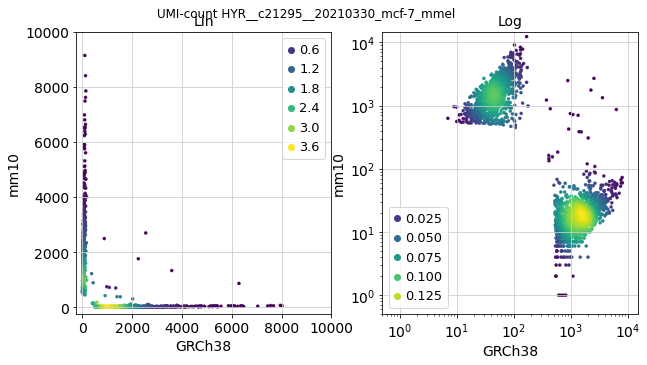

In [10]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(df_adata_colsum_sorted['sum'][10:200000])
plt.xscale("log")
plt.yscale("log")
plt.title(legend[0])

plt.savefig('plts_python/' + legend[0] + '_kneeplot.svg', dpi=150)
plt.close()

# now replace zeros by 1s for the log scale
df_adata_colsum_nozeros = df_adata_colsum_sorted.mask(df_adata_colsum_sorted == 0, 1)
df_adata_colsum_nozeros_sorted = df_adata_colsum_nozeros.sort_values(by = 'sum', axis = 0, ascending = False)

## now plot the barnyard for the top n cells 
df_adata_colsum_nozeros_sorted_top_n = df_adata_colsum_nozeros_sorted

cmap = sns.cubehelix_palette(start=1, light=1, as_cmap=True)
cmap2 = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)

x = df_adata_colsum_nozeros_sorted_top_n['GRCh38']
y = df_adata_colsum_nozeros_sorted_top_n['mm10']
z = df_adata_colsum_nozeros_sorted_top_n['GRCh38'] + df_adata_colsum['mm10']

f, axes = plt.subplots(1, 2, figsize=(10, 5))

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

sns.scatterplot(x = 'GRCh38', y = 'mm10', data = df_adata_colsum_nozeros_sorted_top_n, hue = z, ax=axes[0], palette='viridis', s=10, edgecolor=None)

# sns.kdeplot(x = x, y = y, shade=False, log_scale=True, levels=5, cbar=False, bw_method=0.1, ax=axes[1])


xy = np.vstack([np.log(x),np.log(y)])
z = gaussian_kde(xy)(xy)
sns.scatterplot(x = df_adata_colsum_nozeros_sorted_top_n['GRCh38'], y = df_adata_colsum_nozeros_sorted_top_n['mm10'], hue=z, s=10, edgecolor=None, palette='viridis')

scalemax = 10000# 1.20*max([max(x), max(y)])
scalemin = -0.02*max([max(x), max(y)])
axes[0].set_title('Lin')
axes[0].set_xlim([scalemin, scalemax])
axes[0].set_ylim([scalemin, scalemax])
axes[1].set_title('Log')

scalemax = 1.20*max([max(x), max(y)])
axes[1].set_xlim([0.5, scalemax])
axes[1].set_ylim([0.5, scalemax])
plt.xscale("log")
plt.yscale("log")

suptitle = 'UMI-count ' + legend[0]
f.suptitle(suptitle)
plt.savefig('plts_python/' + legend[0] + '_barnyard_umi.svg', dpi=150)
plt.show()
plt.close()

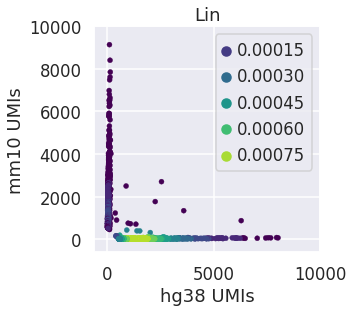

In [11]:
sns.set_style('darkgrid')
sns.set_context('talk')
markersize=25
nbins = 10
# now replace zeros by 1s for the log scale
df_adata_colsum_nozeros = df_adata_colsum_sorted.mask(df_adata_colsum_sorted == 0, 1)
df_adata_colsum_nozeros_sorted = df_adata_colsum_nozeros.sort_values(by = 'sum', axis = 0, ascending = False)

## now plot the barnyard for the top n cells 
df_adata_colsum_nozeros_sorted_top_n = df_adata_colsum_nozeros_sorted

x = df_adata_colsum_nozeros_sorted_top_n['GRCh38']
y = df_adata_colsum_nozeros_sorted_top_n['mm10']

xy = np.vstack([np.log10(x),y])
z = gaussian_kde(xy)(xy)
bins = np.linspace(z.min(), z.max(), nbins)
digitized = np.digitize(z, bins)
bin_means = [z[digitized == i].mean() for i in range(1, len(bins))]
digitized_rescaled = np.interp(digitized, (digitized.min(), digitized.max()), (z.min(), z.max()))

ax = sns.scatterplot(x = 'GRCh38', y = 'mm10', data = df_adata_colsum_nozeros_sorted_top_n, hue = digitized_rescaled, palette='viridis', edgecolor=None, s=markersize)

# sns.kdeplot(x = x, y = y, shade=False, log_scale=True, levels=5, cbar=False, bw_method=0.1, ax=axes[1])
ax.set_title('Lin')
scalemax = 10000# 1.20*max([max(x), max(y)])
scalemin = -0.05*max([max(x), max(y)])
ax.set_xlim([scalemin, scalemax])
ax.set_ylim([scalemin, scalemax])
ax.set(xscale='linear')
ax.set(yscale='linear')

ax.set_aspect('equal', adjustable='box')
ax.set_aspect(1./ax.get_data_ratio())

ax.set_xlabel('hg38 UMIs')
ax.set_ylabel('mm10 UMIs')

plt.savefig('plts_pub/barnyard_umi_markersize'+str(markersize)+'.svg', dpi=150)
plt.show()
plt.close()

In [12]:
df_adata_colsum_nozeros_sorted_top_n

,GRCh38,mm10,sum
ATCGACCTTG_CTCAGGTAAG_TGAGTCTCCT,168.0,12384.0,12552.0
GAACACTGGA_ACCTTGTATG_TCAGAACCAG,103.0,9134.0,9237.0
TTCACAGCTC_GTAAGGTTCA_TGAGCATCTA,131.0,8403.0,8534.0
ACTCGCAATG_GAATCGGTTA_TGAGCATCTA,8022.0,60.0,8082.0
CGCACTTCAT_CCTACCTACC_CGTTCGTAGA,7951.0,73.0,8024.0
...,...,...,...
ACCTGAGATG_ATAGTACGGT_CGTTGTCAGC,414.0,134.0,548.0
CATCTCGTCA_TCGCCTAAGT_TGGATTACAG,544.0,2.0,546.0
CCTGGTATTA_CCTACCTACC_CGGCTGATAC,533.0,13.0,546.0
TCGCACATAC_GACTACCTCA_GAGTAGACCA,539.0,6.0,545.0


In [13]:
df_adata_colsum_nozeros_sorted_top_n.median()

GRCh38     671.5
mm10        35.0
sum       1439.5
dtype: float32

In [14]:
df_adata_colsum_nozeros_sorted_top_n.mean()

GRCh38     961.202637
mm10       793.520020
sum       1754.722656
dtype: float32

In [15]:
df_adata_colsum_nozeros_sorted_top_n['ratio']=df_adata_colsum_nozeros_sorted_top_n['GRCh38']/df_adata_colsum_nozeros_sorted_top_n['sum']

In [20]:
df_adata_colsum_nozeros_sorted_top_n['species']='mixed'

In [21]:
cutoff = 0.95
cutoff2=1-cutoff
df_adata_colsum_nozeros_sorted_top_n['species']='mixed'
df_adata_colsum_nozeros_sorted_top_n['species'][df_adata_colsum_nozeros_sorted_top_n['ratio']>=cutoff]='human'
df_adata_colsum_nozeros_sorted_top_n['species'][df_adata_colsum_nozeros_sorted_top_n['ratio']<=cutoff2]='mouse'
df_adata_colsum_nozeros_sorted_top_n['species'].value_counts()

/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/user/leuven/330/vsc33042/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


human    1235
mouse     846
mixed     169
Name: species, dtype: int64

In [22]:
169/2250

0.07511111111111111

Then I want to cluster (PC + UMAP) and then color by species

In [ ]:
mtx = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/matrix.mtx'
features = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/features.tsv'
barcodes = 'demultiplexed/HYR__c21295__20210330_mcf-7_mmel_S5.Solo.out/Gene/filtered/barcodes.tsv'
data = sc.read_mtx(mtx)
data = data.T
features = pd.read_csv(features, header=None)
barcodes = pd.read_csv(barcodes, header=None)
data.var_names = features[0]
data.obs_names = barcodes[0]

adata = data
adata.var_names_make_unique()
# sc.pl.highest_expr_genes(adata, n_top=20, )

sc.pp.filter_cells(adata, min_genes=80)
sc.pp.filter_genes(adata, min_cells=3)
# sc.pl.highest_expr_genes(adata, n_top=20, )

adata.var['mt'] = adata.var_names.str.startswith('GRCh38_MT-', 'mm10_mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

adata = adata[adata.obs.pct_counts_mt < 5, :]

sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)

sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata)

sc.pl.pca_variance_ratio(adata, log=True)
for n_pcs in [8, 10, 15, 20]:
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=n_pcs)
    sc.tl.umap(adata)
    # sc.pl.umap(adata, color=['GRCh38-MALAT1', 'mm10-Malat1'])

    # Now, make a plot for human vs mouse
    # (see this thread: https://github.com/theislab/scanpy/issues/532):
    list_GRCh38 = [name for name in adata.var_names if name.startswith('GRCh38')]
    list_mm10 = [name for name in adata.var_names if name.startswith('mm10')]

    sc.tl.score_genes(adata, list_GRCh38, score_name='GRCh38_score')
    sc.tl.score_genes(adata, list_mm10, score_name='mm10_score')
    figname = 'pcs_umap_speciessplit.png'
    figtitle =['GRCh38 score - ' + str(n_pcs) + ' PCs', 'mm10 score - ' + str(n_pcs) + ' PCs']

    sc.pl.umap(adata, color= ['GRCh38_score', 'mm10_score'], save=figname, title = figtitle)

In [ ]:
# create a dictionary to map cluster to annotation label
cluster2annotation = {
     '0': 'Human',
     '1': 'Mouse',
}

# add a new `.obs` column called `cell type` by mapping clusters to annotation using pandas `map` function
adata.obs['cell_type'] = adata.obs['leiden'].map(cluster2annotation).astype('category')

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
sc.tl.leiden(adata, resolution=0.1)

In [ ]:
sc.pl.violin(adata, ['n_genes', 'total_counts'], groupby='leiden')

In [ ]:
adata.obs['all']=''

In [ ]:
adata.obs

In [ ]:
ax = sns.violinplot(x='all', y="n_genes", data=adata.obs, palette="muted", hue='cell_type', split=True, scale='count')

In [ ]:
ax = sns.violinplot(x='all', y="total_counts", data=adata.obs, palette="muted", hue='cell_type', split=True, scale='count')

In [ ]:
sc.pl.umap(adata, color='leiden', save='test')

In [ ]:
print(adata.obs['n_genes'].mean())
print(adata.obs['total_counts'].mean())
print(adata.obs['n_genes'].median())
print(adata.obs['total_counts'].median())

0 is human, 1 is mouse

In [ ]:
print(adata.obs[adata.obs['leiden']=='0']['n_genes'].mean())
print(adata.obs[adata.obs['leiden']=='0']['total_counts'].mean())
print(adata.obs[adata.obs['leiden']=='0']['n_genes'].median())
print(adata.obs[adata.obs['leiden']=='0']['total_counts'].median())

In [ ]:
print(adata.obs[adata.obs['leiden']=='1']['n_genes'].mean())
print(adata.obs[adata.obs['leiden']=='1']['total_counts'].mean())
print(adata.obs[adata.obs['leiden']=='1']['n_genes'].median())
print(adata.obs[adata.obs['leiden']=='1']['total_counts'].median())